## Working Directory

In [1]:
import os

os.getcwd()

'C:\\Users\\Tenzing\\Sentiment Analysis'

## Importing required Libraries

In [2]:
import pandas as pd
import numpy as np
import nltk
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
import plotly.graph_objs as go

from plotly.offline import iplot
from collections import defaultdict
from plotly import tools
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.calibration import CalibratedClassifierCV # For probability score output
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

## Loading EV Reviews dataset

In [3]:
data = pd.read_csv("EV_reviews2.csv")

In [4]:
data.head()

,Title,Name,Ratings,Review
0,Lovely bike,10 months ago by Amgoth Suresh,5,"Buying experience is awesome, riding performan..."
1,Rv400 good & bad,1 year ago by Vipin Tyagi,4,Rv400 is good e-bike we are sharing with you o...
2,No more fut futt futtt,1 year ago by Mr Smarty Pants,2,The biggest issue before going electric is ran...
3,Revolt...,1 year ago by Yogesh,4,"Booked on 5th oct and got on Dhanteras, very n..."
4,Super bike.,1 year ago by Divy,5,It's amazing bike. all type of service are nic...


In [5]:
data.isnull().sum()

Title       0
Name        0
Ratings     0
Review     42
dtype: int64

In [6]:
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

In [7]:
data['Text'] = data['Title']+'. ' +data['Review']

In [8]:
data['Ratings'].value_counts()

5    207
1    146
4     88
3     33
2     26
Name: Ratings, dtype: int64

In [9]:
def f(row):
   
    if row['Ratings'] == 1 or row['Ratings'] == 2:
        val = 'Negative'
    elif row['Ratings'] == 3:
        val = 'Neutral'
    else:
        val = 'Positive'
    return val

In [10]:
data['sentiment'] = data.apply(f, axis=1)
data.head()

,Title,Name,Ratings,Review,Text,sentiment
0,Lovely bike,10 months ago by Amgoth Suresh,5,"Buying experience is awesome, riding performan...","Lovely bike. Buying experience is awesome, rid...",Positive
1,Rv400 good & bad,1 year ago by Vipin Tyagi,4,Rv400 is good e-bike we are sharing with you o...,Rv400 good & bad. Rv400 is good e-bike we are ...,Positive
2,No more fut futt futtt,1 year ago by Mr Smarty Pants,2,The biggest issue before going electric is ran...,No more fut futt futtt. The biggest issue befo...,Negative
3,Revolt...,1 year ago by Yogesh,4,"Booked on 5th oct and got on Dhanteras, very n...",Revolt.... Booked on 5th oct and got on Dhante...,Positive
4,Super bike.,1 year ago by Divy,5,It's amazing bike. all type of service are nic...,Super bike.. It's amazing bike. all type of se...,Positive


In [11]:
data = data[data.sentiment != "Neutral"]
data.reset_index(drop=True, inplace=True)

In [12]:
data.drop(['Title','Review','Name','Ratings'], axis =1, inplace=True)

In [13]:
data1 = data.copy(deep=True)
data2 = data.copy(deep=True)
data3 = data.copy(deep=True)

In [14]:
data1.head(20)

,Text,sentiment
0,"Lovely bike. Buying experience is awesome, rid...",Positive
1,Rv400 good & bad. Rv400 is good e-bike we are ...,Positive
2,No more fut futt futtt. The biggest issue befo...,Negative
3,Revolt.... Booked on 5th oct and got on Dhante...,Positive
4,Super bike.. It's amazing bike. all type of se...,Positive
5,Exceptional review. This is simply amazing and...,Positive
6,"Rock and roll. Battery life is good, I like th...",Positive
7,Revolt RV 400 Review. I seen this bike on road...,Positive
8,Piece of shit. Would highly recommend not to. ...,Negative
9,"A blessing for daily commuters.. We'll, this b...",Positive


## Data Understanding

In [15]:
# Count number of words in a review

data1['word_count'] = data1['Text'].apply(lambda x : len(str(x).split(" ")))

In [16]:
# Count number of characters in a review

data1['char_count'] = data1['Text'].str.len() ## this also includes spaces

In [17]:
# Average Word Length

def avg_word(sentence):
    words = str(sentence).split()    
    return (sum(len(word) for word in words)/len(words))

data1['avg_word'] = data1['Text'].apply(lambda x: avg_word(x))

In [18]:
# Number of numerics

data1['numerics'] = data1['Text'].apply(lambda x: len([x for x in str(x).split() if x.isdigit()]))

In [19]:
# Number of Uppercase words

data1['upper_case'] = data1['Text'].apply(lambda x: len([x for x in str(x).split() if x.isupper()]))

In [20]:
data1.head()

,Text,sentiment,word_count,char_count,avg_word,numerics,upper_case
0,"Lovely bike. Buying experience is awesome, rid...",Positive,58,341,4.896552,0,1
1,Rv400 good & bad. Rv400 is good e-bike we are ...,Positive,62,338,4.467742,0,0
2,No more fut futt futtt. The biggest issue befo...,Negative,305,1724,4.701987,1,2
3,Revolt.... Booked on 5th oct and got on Dhante...,Positive,58,378,5.534483,1,0
4,Super bike.. It's amazing bike. all type of se...,Positive,45,255,4.688889,0,1


## Exploratory Data Analysis

### Review Rating Distribution

In [21]:
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [22]:
data3['sentiment'].iplot(
    kind='hist',
    xTitle='Ratings',
    linecolor='black',
    yTitle='count',
    colors='darkorchid',
    title='Review Rating Distribution')

### Review Text Length Distribution

In [23]:
data3['Text_len'] = data3['Text'].astype(str).apply(len)

data3['Text_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='Review length',
    linecolor='black',
    yTitle='count',
    colors='Blue',
    title='Review Text Length Distribution')

### Review Text Word Count Distribution

In [24]:
data3['word_count'] = data3['Text'].apply(lambda x: len(str(x).split()))

data3['word_count'].iplot(
    kind='hist',
    bins=100,
    xTitle='Word count',
    linecolor='black',
    yTitle='count',
    colors='Red',
    title='Review Text Word Count Distribution')

## N-gram Analysis

##### Basic Text processing for N-gram Analysis

In [25]:
# remove non-alphabetical characters
data3['Text'] = data3['Text'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))

# Lower Casing
data3['Text'] = data3['Text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Tokenization
data3['token'] = data3['Text'].apply(lambda x : str(x).split(" "))

# Stopwords Removal
stop = stopwords.words('english')
for i in range(0,len(data3)): 
    data3.at[i,"token"] = [w for w in data3['token'][i] if w not in stop]
    
# Stemming
ps = PorterStemmer()

data3['stem'] = data3['token'].apply(lambda x: ' '.join([ps.stem(i) for i in x]))
data3.head()

,Text,sentiment,Text_len,word_count,token,stem
0,lovely bike buying experience is awesome ridin...,Positive,341,58,"[lovely, bike, buying, experience, awesome, ri...",love bike buy experi awesom ride perform great...
1,rv good bad rv is good e bike we are sharing w...,Positive,338,62,"[rv, good, bad, rv, good, e, bike, sharing, go...",rv good bad rv good e bike share good bad expe...
2,no more fut futt futtt the biggest issue befor...,Negative,1724,302,"[fut, futt, futtt, biggest, issue, going, elec...",fut futt futtt biggest issu go electr rang per...
3,revolt booked on th oct and got on dhanteras v...,Positive,378,58,"[revolt, booked, th, oct, got, dhanteras, nice...",revolt book th oct got dhantera nice experi ri...
4,super bike it s amazing bike all type of servi...,Positive,255,45,"[super, bike, amazing, bike, type, service, ni...",super bike amaz bike type servic nice look bet...


In [26]:
#Filtering data
review_pos = data3[data3["sentiment"]=='Positive'].dropna()

review_neg = data3[data3["sentiment"]=='Negative'].dropna()

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in stopwords.words('english')]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

### Monogram Analysis

In [27]:
# Positive Reviews

freq_dict = defaultdict(int)
for sent in review_pos["Text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

# Negative Reviews

freq_dict = defaultdict(int)
for sent in review_neg["Text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'red')

# Creating two subplots

fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of positive reviews",
                                          "Frequent words of negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
iplot(fig, filename='word-plots')

C:\Users\Tenzing\anaconda3\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



### Bigram analysis

In [28]:
# Positive Reviews

freq_dict = defaultdict(int)
for sent in review_pos["Text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

# Negative Reviews

freq_dict = defaultdict(int)
for sent in review_neg["Text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'brown')

# Creating two subplots

fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.04,horizontal_spacing=0.25,
                          subplot_titles=["Bigram plots of Positive reviews",
                                          "Bigram plots of Negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig['layout'].update(height=1000, width=800, paper_bgcolor='rgb(233,233,233)', title="Bigram Plots")
iplot(fig, filename='word-plots')

### Trigram Analysis

In [29]:
# Positive Reviews

for sent in review_pos["Text"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

# Negative Reviews

freq_dict = defaultdict(int)
for sent in review_neg["Text"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'red')

# Creating two subplots

fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.04, horizontal_spacing=0.05,
                          subplot_titles=["Tri-gram plots of Positive reviews", 
                                          "Tri-gram plots of Negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
iplot(fig, filename='word-plots')

## Word Cloud

### Positive reviews

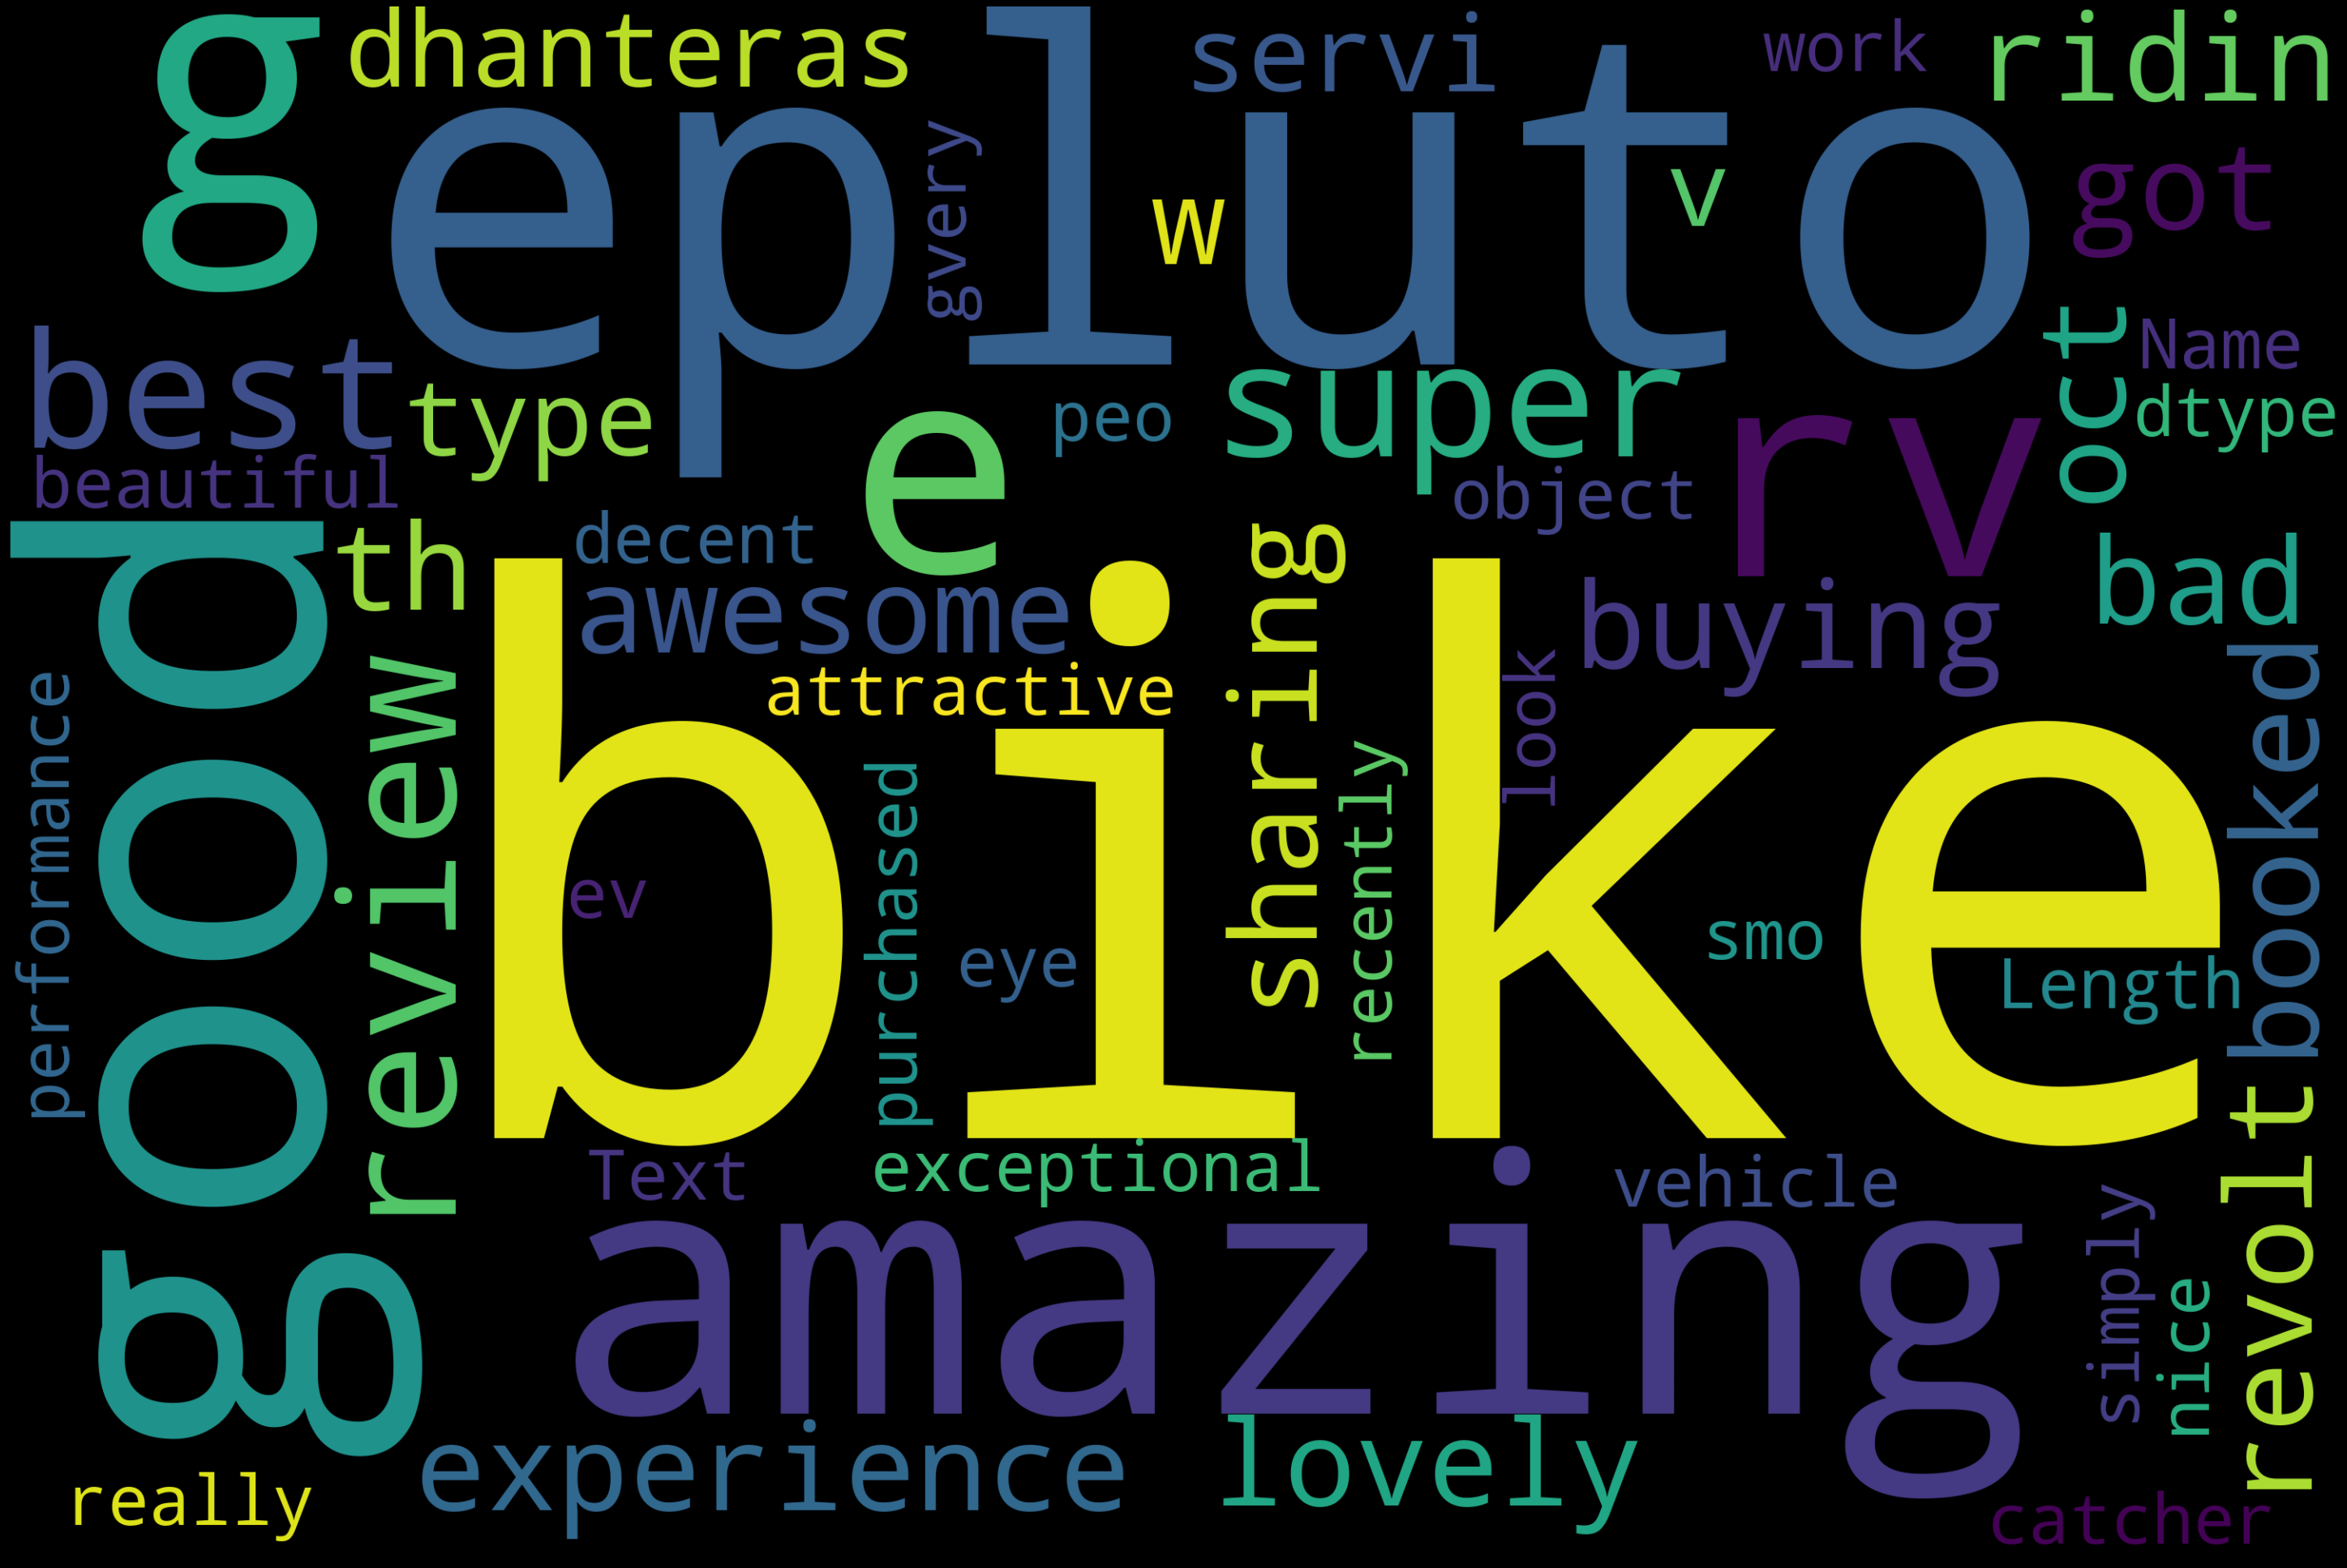

In [30]:
text = review_pos["Text"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = stop).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Negative Reviews

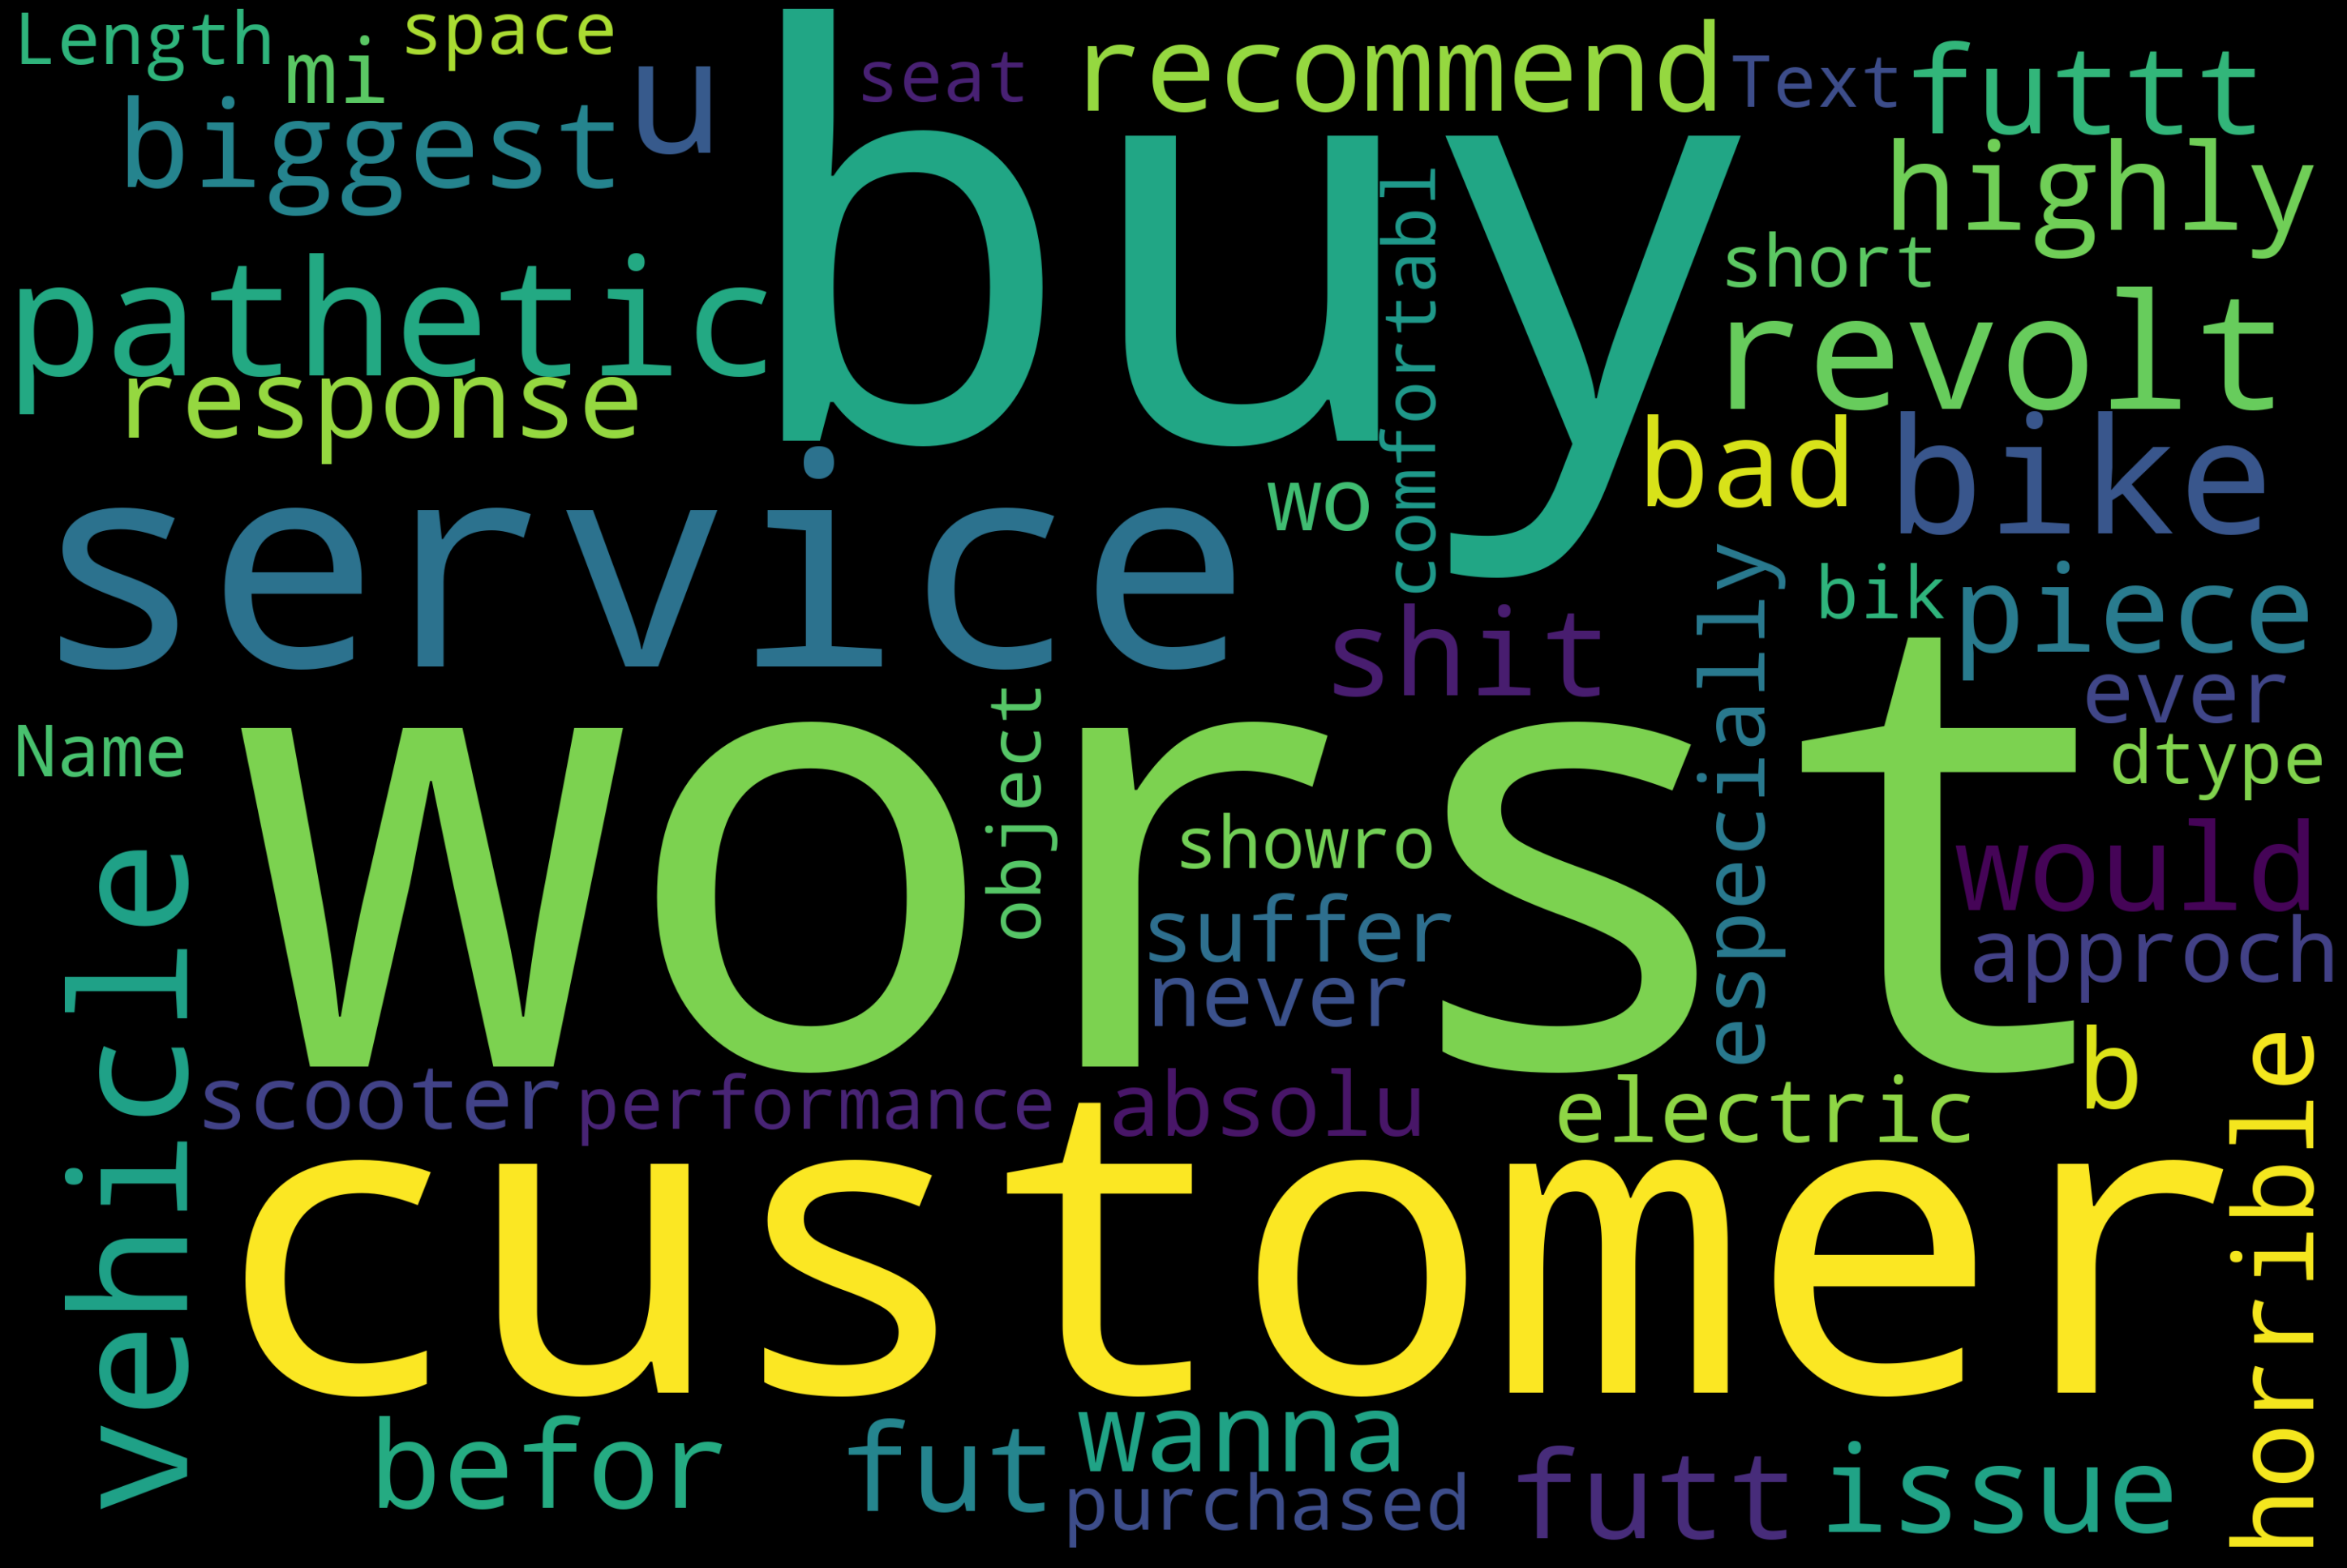

In [31]:
text = review_neg["Text"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = stop).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Spliting Data

In [32]:
X = data1['Text']
y = data1['sentiment']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10, stratify=y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(326,)
(141,)
(326,)
(141,)


## Text Preprocessing

### Stemming

In [34]:
# Defining function for Stemming

stemmer = PorterStemmer()

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

### Tokenization and Stopwords removal

In [35]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tenzing\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [36]:
# Defining function for Tokenization and Stopwords removal

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    stems = stem_tokens(tokens, stemmer)
    return ' '.join(stems)

### Punctuations and Lowercase

In [37]:
intab = string.punctuation
outtab = "                                "
trantab = str.maketrans(intab, outtab)

In [38]:
# Cleaning Train data

corpus = []
for text in X_train:
    text = text.lower()
    text = text.translate(trantab)
    text = tokenize(text)
    corpus.append(text)
     
# Cleaning Test data

test_set = []
for text in X_test:
    text = text.lower()
    text = text.translate(trantab)
    text=tokenize(text)
    test_set.append(text)

### Count Vectorizer

In [39]:
count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()

# Train data

X_train_counts = count_vect.fit_transform(corpus)        
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# Test data

X_new_counts = count_vect.transform(test_set)
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

## Comparing cleaned data

In [40]:
df = pd.DataFrame({'Before': X_train, 'After': corpus})
print(df.head(5))
prediction = dict()

                                                Before  \
380  Not worth for money, all things are worst qua....   
459  Best ev vehicle. Super in bike. Really good wo...   
84   Hero Electric Optima review. Best riding on ro...   
318  Dissatisfaction. Very burst electric bike. I a...   
36   Still not available at my place hyderabad. I h...   

                                                 After  
380  worth money thing worst qua fake speedomet fak...  
459  best ev vehicl super bike realli good work goo...  
84   hero electr optima review best ride road best ...  
318  dissatisfact burst electr bike satisfi charg s...  
36   still avail place hyderabad seen video revolt ...  


## Train and evaluate Logistic Regression Classifier

In [41]:
BLR = LogisticRegression(C=1e5)
BLR.fit(X_train_tfidf, y_train)

LogisticRegression(C=100000.0)

In [42]:
prediction['Logistic'] = BLR.predict(X_test_tfidf)

In [43]:
print(metrics.classification_report(y_test, prediction['Logistic'], target_names = ["positive", "negative"]))

              precision    recall  f1-score   support

    positive       0.93      0.77      0.84        52
    negative       0.88      0.97      0.92        89

    accuracy                           0.89       141
   macro avg       0.90      0.87      0.88       141
weighted avg       0.90      0.89      0.89       141



In [44]:
cm = confusion_matrix(y_test, prediction['Logistic'])
cm

array([[40, 12],
       [ 3, 86]], dtype=int64)

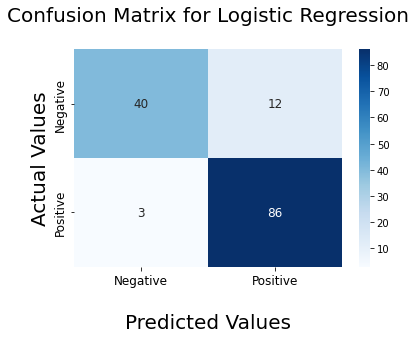

In [45]:
ax = sns.heatmap(cm, annot=True, cmap="Blues",annot_kws={"size": 12})

ax.set_title('Confusion Matrix for Logistic Regression\n', fontsize = 20);
ax.set_xlabel('\nPredicted Values', fontsize = 20)
ax.set_ylabel('Actual Values', fontsize = 20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negative','Positive'], fontsize = 12)
ax.yaxis.set_ticklabels(['Negative','Positive'], fontsize = 12)

## Display the visualization of the Confusion Matrix.
plt.show()

In [46]:
def confusion_metrics (conf_matrix):
# save confusion matrix and slice into four pieces
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    print('True Positives  :', TP)
    print('True Negatives  :', TN)
    print('False Positives :', FP)
    print('False Negatives :', FN)
    
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
    
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    
    # calculate precision
    conf_precision = (TN / float(TN + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    print('-'*25)
    print(f'Accuracy           : {round(conf_accuracy,2)}') 
    print(f'Mis-Classification : {round(conf_misclassification,2)}') 
    print(f'Sensitivity        : {round(conf_sensitivity,2)}') 
    print(f'Specificity        : {round(conf_specificity,2)}') 
    print(f'Precision          : {round(conf_precision,2)}')
    print(f'f_1 Score          : {round(conf_f1,2)}')

In [47]:
confusion_metrics(cm)

True Positives  : 86
True Negatives  : 40
False Positives : 12
False Negatives : 3
-------------------------
Accuracy           : 0.89
Mis-Classification : 0.11
Sensitivity        : 0.97
Specificity        : 0.77
Precision          : 0.77
f_1 Score          : 0.86


## Train and evaluate Naive Bayes Gaussian Classifier

In [48]:
GNB = GaussianNB()
GNB.fit(X_train_tfidf.toarray(), y_train)

GaussianNB()

In [49]:
prediction['Naive Bayes'] = GNB.predict(X_test_tfidf.toarray())

In [50]:
print(metrics.classification_report(y_test, prediction['Naive Bayes'], target_names = ["positive", "negative"]))

              precision    recall  f1-score   support

    positive       0.67      0.77      0.71        52
    negative       0.85      0.78      0.81        89

    accuracy                           0.77       141
   macro avg       0.76      0.77      0.76       141
weighted avg       0.78      0.77      0.78       141



In [51]:
cm = confusion_matrix(y_test, prediction['Naive Bayes'])
cm

array([[40, 12],
       [20, 69]], dtype=int64)

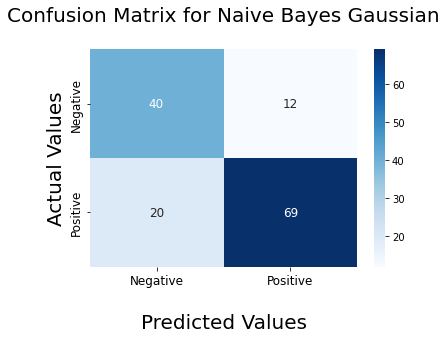

In [52]:
ax = sns.heatmap(cm, annot=True, cmap="Blues", annot_kws = {"size": 12})

ax.set_title('Confusion Matrix for Naive Bayes Gaussian\n', fontsize = 20);
ax.set_xlabel('\nPredicted Values', fontsize = 20)
ax.set_ylabel('Actual Values', fontsize = 20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negative','Positive'], fontsize = 12)
ax.yaxis.set_ticklabels(['Negative','Positive'], fontsize = 12)

## Display the visualization of the Confusion Matrix.
plt.show()

In [53]:
confusion_metrics(cm)

True Positives  : 69
True Negatives  : 40
False Positives : 12
False Negatives : 20
-------------------------
Accuracy           : 0.77
Mis-Classification : 0.23
Sensitivity        : 0.78
Specificity        : 0.77
Precision          : 0.77
f_1 Score          : 0.77


## Train and evaluate KNN

In [54]:
KNN = KNeighborsClassifier(n_neighbors = 3)
KNN.fit(X_train_tfidf, y_train)

KNeighborsClassifier(n_neighbors=3)

In [55]:
prediction['KNN'] = KNN.predict(X_test_tfidf)

In [56]:
print(metrics.classification_report(y_test, prediction['KNN'], target_names = ["positive", "negative"]))

              precision    recall  f1-score   support

    positive       0.85      0.75      0.80        52
    negative       0.86      0.92      0.89        89

    accuracy                           0.86       141
   macro avg       0.86      0.84      0.84       141
weighted avg       0.86      0.86      0.86       141



In [57]:
cm = confusion_matrix(y_test, prediction['KNN'])
cm

array([[39, 13],
       [ 7, 82]], dtype=int64)

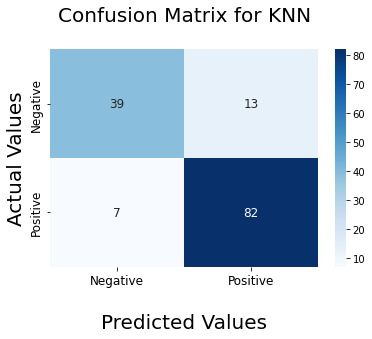

In [58]:
ax = sns.heatmap(cm, annot=True, cmap="Blues", annot_kws = {"size": 12})

ax.set_title('Confusion Matrix for KNN\n', fontsize = 20);
ax.set_xlabel('\nPredicted Values', fontsize = 20)
ax.set_ylabel('Actual Values', fontsize = 20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negative','Positive'], fontsize = 12)
ax.yaxis.set_ticklabels(['Negative','Positive'], fontsize = 12)

## Display the visualization of the Confusion Matrix.
plt.show()

In [59]:
confusion_metrics(cm)

True Positives  : 82
True Negatives  : 39
False Positives : 13
False Negatives : 7
-------------------------
Accuracy           : 0.86
Mis-Classification : 0.14
Sensitivity        : 0.92
Specificity        : 0.75
Precision          : 0.75
f_1 Score          : 0.83


## Train and evaluate RandomForest Classifier

In [60]:
RF = RandomForestClassifier()
RF.fit(X_train_tfidf, y_train)

RandomForestClassifier()

In [61]:
prediction['RF'] = RF.predict(X_test_tfidf)

In [62]:
print(metrics.classification_report(y_test, prediction['RF'], target_names = ["positive", "negative"]))

              precision    recall  f1-score   support

    positive       0.95      0.71      0.81        52
    negative       0.85      0.98      0.91        89

    accuracy                           0.88       141
   macro avg       0.90      0.84      0.86       141
weighted avg       0.89      0.88      0.87       141



In [63]:
cm = confusion_matrix(y_test, prediction['RF'])
cm

array([[37, 15],
       [ 2, 87]], dtype=int64)

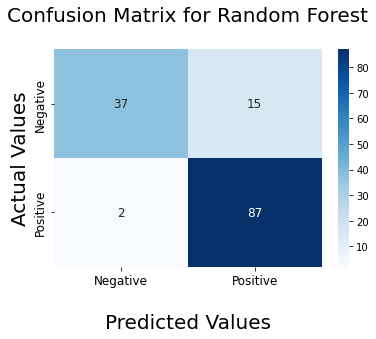

In [64]:
ax = sns.heatmap(cm, annot=True, cmap="Blues", annot_kws = {"size": 12})

ax.set_title('Confusion Matrix for Random Forest\n', fontsize = 20);
ax.set_xlabel('\nPredicted Values', fontsize = 20)
ax.set_ylabel('Actual Values', fontsize = 20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negative','Positive'], fontsize = 12)
ax.yaxis.set_ticklabels(['Negative','Positive'], fontsize = 12)

## Display the visualization of the Confusion Matrix.
plt.show()

In [65]:
confusion_metrics(cm)

True Positives  : 87
True Negatives  : 37
False Positives : 15
False Negatives : 2
-------------------------
Accuracy           : 0.88
Mis-Classification : 0.12
Sensitivity        : 0.98
Specificity        : 0.71
Precision          : 0.71
f_1 Score          : 0.82


## Train and evaluate SVM Classifier

In [66]:
SVC = LinearSVC(max_iter=100000)
SVM = CalibratedClassifierCV(SVC) 
SVM.fit(X_train_tfidf, y_train)

CalibratedClassifierCV(base_estimator=LinearSVC(max_iter=100000))

In [67]:
prediction['SVM'] = SVM.predict(X_test_tfidf)

In [68]:
print(metrics.classification_report(y_test, prediction['SVM'], target_names = ["positive", "negative"]))

              precision    recall  f1-score   support

    positive       0.93      0.81      0.87        52
    negative       0.90      0.97      0.93        89

    accuracy                           0.91       141
   macro avg       0.91      0.89      0.90       141
weighted avg       0.91      0.91      0.91       141



In [69]:
cm = confusion_matrix(y_test, prediction['SVM'])
cm

array([[42, 10],
       [ 3, 86]], dtype=int64)

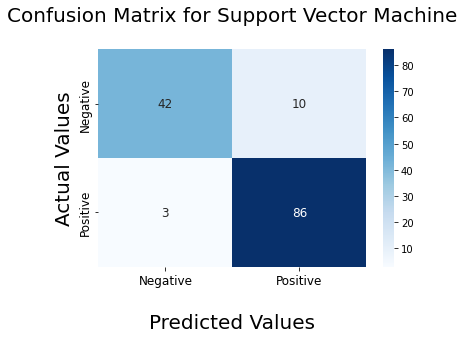

In [70]:
ax = sns.heatmap(cm, annot=True, cmap="Blues", annot_kws = {"size": 12})

ax.set_title('Confusion Matrix for Support Vector Machine\n', fontsize = 20);
ax.set_xlabel('\nPredicted Values', fontsize = 20)
ax.set_ylabel('Actual Values', fontsize = 20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negative','Positive'], fontsize = 12)
ax.yaxis.set_ticklabels(['Negative','Positive'], fontsize = 12)

## Display the visualization of the Confusion Matrix.
plt.show()

In [71]:
confusion_metrics(cm)

True Positives  : 86
True Negatives  : 42
False Positives : 10
False Negatives : 3
-------------------------
Accuracy           : 0.91
Mis-Classification : 0.09
Sensitivity        : 0.97
Specificity        : 0.81
Precision          : 0.81
f_1 Score          : 0.88


## ROC and AUC

0.867761452031115
0.7722558340535868
0.8356741573033708
0.844533275713051
0.8869922212618843


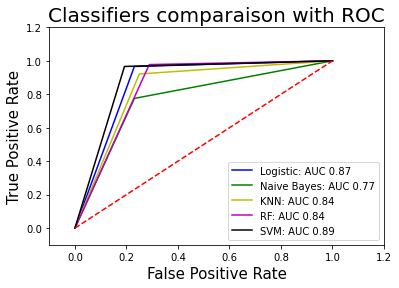

In [72]:
def formatt(x):
    if x == 'Negative':
        return 0
    return 1
vfunc = np.vectorize(formatt)

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k', 'c', 'r']
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.map(formatt), vfunc(predicted))
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1
    
plt.rcParams["figure.figsize"] = (12,8)
plt.title('Classifiers comparaison with ROC', fontsize = 20)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate', fontsize = 15)
plt.xlabel('False Positive Rate', fontsize = 15)
plt.show()